In [2]:
import torch
print(torch.__version__)

2.5.1+cu121


Using device: cpu
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 51.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.07MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.0MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.92MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/50] | D Loss: 0.0424 | G Loss: 5.6268
Epoch [2/50] | D Loss: 0.0654 | G Loss: 6.5409
Epoch [3/50] | D Loss: 0.0813 | G Loss: 4.6273
Epoch [4/50] | D Loss: 0.1161 | G Loss: 3.8165
Epoch [5/50] | D Loss: 0.2434 | G Loss: 4.1413
Epoch [6/50] | D Loss: 0.1249 | G Loss: 4.0033
Epoch [7/50] | D Loss: 0.1018 | G Loss: 4.5923
Epoch [8/50] | D Loss: 0.0421 | G Loss: 8.8992
Epoch [9/50] | D Loss: 0.0408 | G Loss: 6.3480
Epoch [10/50] | D Loss: 0.1015 | G Loss: 9.0524
Epoch [11/50] | D Loss: 0.0622 | G Loss: 6.1829
Epoch [12/50] | D Loss: 0.1470 | G Loss: 4.5599
Epoch [13/50] | D Loss: 0.1137 | G Loss: 8.5193
Epoch [14/50] | D Loss: 0.3327 | G Loss: 2.4254
Epoch [15/50] | D Loss: 0.4087 | G Loss: 3.8173
Epoch [16/50] | D Loss: 0.2608 | G Loss: 5.1667
Epoch [17/50] | D Loss: 0.2551 | G Loss: 4.1842
Epoch [18/50] | D Loss: 0.0831 | G Loss: 4.8405
Epoch [19/50] | D Loss: 0.1448 | G Loss: 5.6081
Epoch [20/50] | D Loss: 0.3390 | G Loss: 4.3063
Epoch [21/50] | D Loss: 0.2561 | G Loss: 4.1593
E

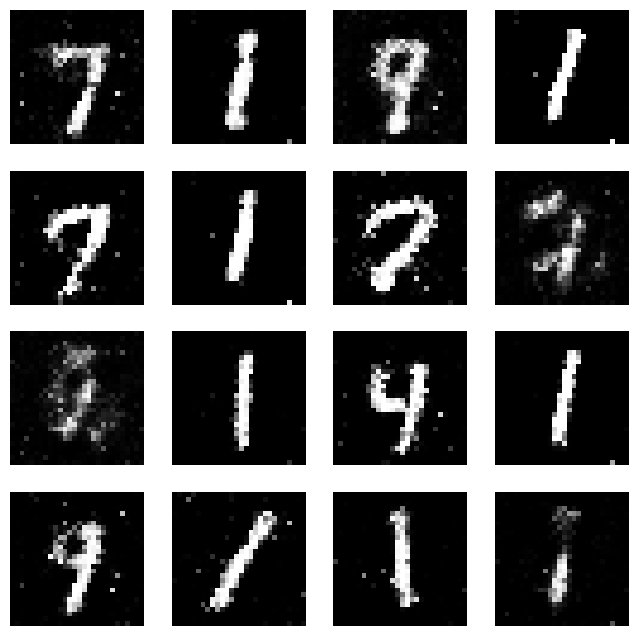

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  ])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)


# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


latent_dim = 100
img_dim = 28 * 28

generator = Generator(input_dim=latent_dim, output_dim=img_dim).to(device)
discriminator = Discriminator(input_dim=img_dim).to(device)


criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

epochs = 50

for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        batch_size = real_imgs.size(0)

        real_imgs = real_imgs.view(batch_size, -1).to(device)

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)


        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise)
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

import matplotlib.pyplot as plt
import numpy as np

def save_fake_images(generator, latent_dim, n_images=16):
    noise = torch.randn(n_images, latent_dim).to(device)
    fake_images = generator(noise).detach().cpu().numpy()
    fake_images = 0.5 * (fake_images + 1)  # إعادة القيم إلى [0, 1]
    fake_images = fake_images.reshape(-1, 28, 28)

    plt.figure(figsize=(8, 8))
    for i in range(n_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

save_fake_images(generator, latent_dim)
